<h1><center><font size="25">Forecasting with LSTM models</font></center></h1>

<center><b>Joaquín Amat Rodrigo, Javier Escobar Ortiz</b></center>

<center><i>September, 2023</i></center>

**More about forecasting**

+ [Introduction to forecasting with skforecast](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)
+ [Forecasting time series with gradient boosting: Skforecast, XGBoost, LightGBM and CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html)
+ [Forecasting electricity demand with Python](https://www.cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html)
+ [Forecasting web traffic with machine learning and Python](https://www.cienciadedatos.net/documentos/py37-forecasting-web-traffic-machine-learning.html)
+ [Bitcoin price prediction with Python, when the past does not repeat itself](https://www.cienciadedatos.net/documentos/py41-forecasting-cryptocurrency-bitcoin-machine-learning-python.html)
+ [Prediction intervals in forecasting models](https://www.cienciadedatos.net/documentos/py42-forecasting-prediction-intervals-machine-learning.html)
+ [Intermittent demand forecasting with skforecast](https://www.cienciadedatos.net/documentos/py48-intermittent-demand-forecasting)

<p align="center"><img src='https://github.com/JoaquinAmatRodrigo/skforecast/raw/master/docs/img/banner-landing-page-skforecast.png'style="width: 600px"></p>

## Introdución


<p align="center"><img src='lstm1.png'style="width: 600px"></p>

## Librerías

In [119]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/fernandocarazo/Documents/git-repos/skforecast'

In [120]:
#!pip install tensorflow
#!pip install torch -f https://download.pytorch.org/whl/torch_stable.html
#!pip install pytorch-forecasting

In [121]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
# ==============================================================================
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from sklearn.preprocessing import MinMaxScaler

# Tensorflow
# ==============================================================================
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Input, Reshape, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax, Nadam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping


## Datos

In [122]:
# ---------------------------------------------------------------------------- #
#                               Downloading data                               #
# ---------------------------------------------------------------------------- #

url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url)
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
print(data.index.to_series().diff().dt.total_seconds().value_counts())
data = data.asfreq('H')
data = data.sort_index()
data = data.drop(columns=['workingday', "weather"])
data.head()

date_time
3600.0    17543
Name: count, dtype: int64


,holiday,temp,atemp,hum,windspeed,users,month,hour,weekday
date_time,,,,,,,,,
2011-01-01 00:00:00,0.0,9.84,14.395,81.0,0.0,16.0,1,0,5
2011-01-01 01:00:00,0.0,9.02,13.635,80.0,0.0,40.0,1,1,5
2011-01-01 02:00:00,0.0,9.02,13.635,80.0,0.0,32.0,1,2,5
2011-01-01 03:00:00,0.0,9.84,14.395,75.0,0.0,13.0,1,3,5
2011-01-01 04:00:00,0.0,9.84,14.395,75.0,0.0,1.0,1,4,5


In [123]:
# ---------------------------------------------------------------------------- #
#                          Split train-validation-test                         #
# ---------------------------------------------------------------------------- #

end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Dates validacion : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Dates test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


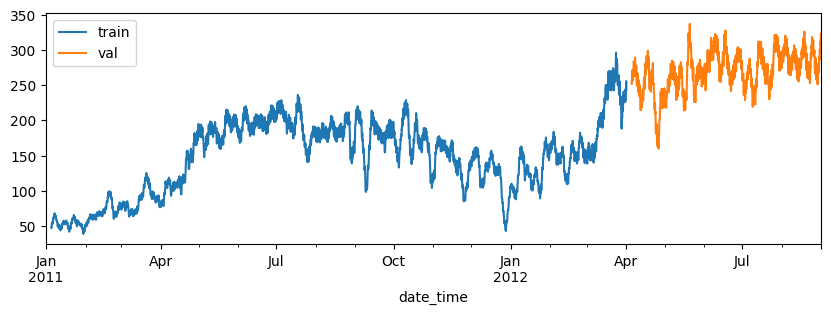

In [124]:
# ----------------------------------- Users ---------------------------------- #
fig, ax = plt.subplots(figsize=(10,3))
data_train[["users"]].rolling(100).mean().plot(ax=ax, label="train")
data_val[["users"]].rolling(100).mean().plot(ax=ax, label="val")
ax.legend(["train", "val"]) 

## Modelo LSTM con tensorflow-keras

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

https://www.tensorflow.org/tutorials/structured_data/time_series


We are working with a univariate series, so the number of features is one, for one variable.

The number of time steps as input is the number of lags used as predictors.

We almost always have multiple samples, therefore, the model will expect the input component of training data to have the dimensions or shape: [samples, timesteps, features]

# Multi-series, multi-step

In [128]:
levels = ["users", "temp", "hum"] # , 
lags=12
steps=5

# llevar el compile al create model

model = create_and_compile_model(
    series=data_train,
    lags=lags,
    steps=steps,
    levels = levels,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[128, 64],
    optimizer=Adam(learning_rate=0.01), 
    loss= MeanSquaredError()
)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 12, 9)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 12, 100)           44000     
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dense_9 (Dense)             (None, 128)               6528      
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 15)                975       
                                                                 
 reshape_3 (Reshape)         (None, 5, 3)              0   

In [129]:
forecaster = ForecasterRnn(
    regressor=model, 
    levels=levels, 
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs":100,
        "batch_size":128,
        "callbacks":[EarlyStopping(monitor='val_loss', patience=10)],
        "series_val":data_val,
    },
)


In [130]:
forecaster.fit(
    data_train)

Epoch 1/100
86/86 [==============================] - 12s 63ms/step - loss: 0.0323 - val_loss: 0.0396
Epoch 2/100
86/86 [==============================] - 4s 46ms/step - loss: 0.0120 - val_loss: 0.0287
Epoch 3/100
86/86 [==============================] - 5s 55ms/step - loss: 0.0104 - val_loss: 0.0249
Epoch 4/100
86/86 [==============================] - 5s 55ms/step - loss: 0.0092 - val_loss: 0.0282
Epoch 5/100
86/86 [==============================] - 5s 57ms/step - loss: 0.0084 - val_loss: 0.0213
Epoch 6/100
86/86 [==============================] - 6s 71ms/step - loss: 0.0077 - val_loss: 0.0189
Epoch 7/100
86/86 [==============================] - 7s 79ms/step - loss: 0.0068 - val_loss: 0.0189
Epoch 8/100
86/86 [==============================] - 5s 58ms/step - loss: 0.0065 - val_loss: 0.0191
Epoch 9/100
86/86 [==============================] - 5s 53ms/step - loss: 0.0062 - val_loss: 0.0159
Epoch 10/100
86/86 [==============================] - 4s 46ms/step - loss: 0.0057 - val_loss: 0.016

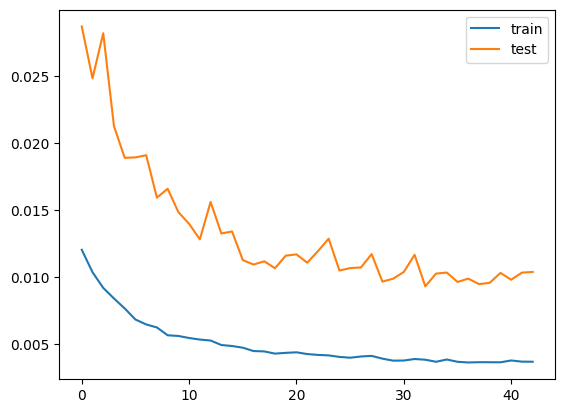

In [131]:
# ---------------------------------------------------------------------------- #
#                                 Plot history                                 #
# ---------------------------------------------------------------------------- #

def plot_history(history):
    plt.plot(history['loss'][1:], label='train')
    plt.plot(history['val_loss'][1:], label='test')
    plt.legend()
    plt.show()
    
plot_history(forecaster.history)
    

In [132]:
# ---------------------------------------------------------------------------- #
#                                    Predict                                   #
# ---------------------------------------------------------------------------- #

predictions = forecaster.predict()

tensorflow WARNING 5 out of the last 17 calls to <function Model.make_predict_function.<locals>.predict_function at 0x14619cfe0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 2s 2s/step


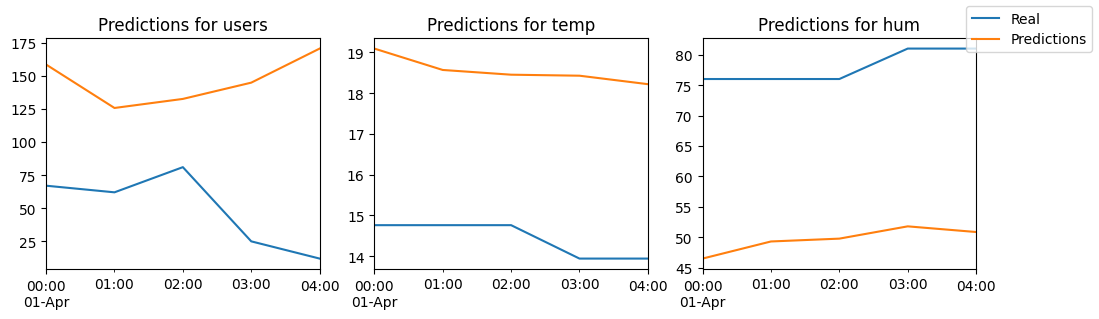

In [133]:
# ---------------------------------------------------------------------------- #
#                               Plot predictions                               #
# ---------------------------------------------------------------------------- #

fig, ax = plt.subplots(ncols=3, figsize=(12, 3) )
for i, ll in enumerate(levels):
    ax[i].set_title(f'Predictions for {ll}')
    data_val.loc[predictions.index, ll].plot(ax=ax[i], label="Real")
    predictions[ll].squeeze().plot(ax=ax[i], label="Predictions")
# fig.legend(["Real", "Predictions"])
fig.legend(["Real", "Predictions"])
plt.show()

## Información de sesión

In [134]:
import session_info
session_info.show(html=False)

-----
debugpy             1.8.0
ipykernel           6.25.2
keras               2.13.1
matplotlib          3.7.3
numpy               1.24.3
pandas              2.0.3
seaborn             0.12.2
session_info        1.0.0
skforecast          0.10.0
sklearn             1.3.0
tensorflow          2.13.0
-----
IPython             8.15.0
jupyter_client      8.3.1
jupyter_core        5.3.1
-----
Python 3.11.5 (main, Sep 11 2023, 08:19:27) [Clang 14.0.6 ]
macOS-10.16-x86_64-i386-64bit
-----
Session information updated at 2023-10-14 00:52


# Dev

## Bibliografía
<br>

Linear Models with R by Julian J.Faraway [libro](https://www.amazon.es/gp/product/1439887330/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1439887330&linkId=e9ca62e854567fb3f9d0ea044f084b11)

OpenIntro Statistics: Fourth Edition by David Diez, Mine Çetinkaya-Rundel, Christopher Barr [libro](https://www.amazon.es/gp/product/1943450072/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1943450072&linkId=a8b49fab17a559d33901ee804a9b5737)

Introduction to Machine Learning with Python: A Guide for Data Scientists [libro](https://www.amazon.es/gp/product/1449369413/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1449369413&linkId=e07f892d9e2c458e8144303901ea9580)

Points of Significance: Association, correlation and causation. Naomi Altman & Martin Krzywinski Nature Methods

https://en.wikipedia.org/wiki/Co



In [135]:
%%html
<style>
.text_cell_render p {
    text-align: justify;
    font-family: 'Open Sans','Helvetica Neue',Helvetica,Arial,sans-serif;
    line-height: 1.5;
    font-weight: 400;
    text-shadow: none;
    color: #333333;
    text-rendering: optimizeLegibility;
    letter-spacing: +0.1px;
    margin-bottom: 1.15rem;
    font-size: 1.15em
}

div.admonition.note {
    text-align: justify;
    font-family: 'Open Sans','Helvetica Neue',Helvetica,Arial,sans-serif;
    line-height: 1.5;
    font-weight: 400;
    text-shadow: none;
    color: #333333;
    text-rendering: optimizeLegibility;
    letter-spacing: +0.1px;
    margin-bottom: 1.15rem;
    font-size: 15px;
}


#notebook-container {
    background-color: #fcfcfc;
}

div.inner_cell {
    margin-right: 5%;
}

.output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
}

.rendered_html code {
    background-color: #f2f2f2;
    font-family: monospace;
    color: #a20505;
    font-size: 15px;
    padding: 1px 1px;
    border: solid;
    border-color: darkgray;
    border-width: thin;
}

.rendered_html h1 {
    padding-top: 50px;
}

.rendered_html h2 {
    font-size: 30px;
    margin-top: 0;
    font-size: 2.488em;
}

.rendered_html h3 {
    font-size: 25px;
}

.rendered_html h4 {
    font-size: 20px;
}

</style>

**¿Cómo citar este documento?**

<p style="text-align:left"><font size="3" color="#555">
TITULO DEL DOCUMENTO by AUTOR, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/documentos/pystats05-correlacion-lineal-python.html

    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by AUTOR is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.